### Figure 1: Showing the start up time of vLLM for different versions using OPT-6.7B model

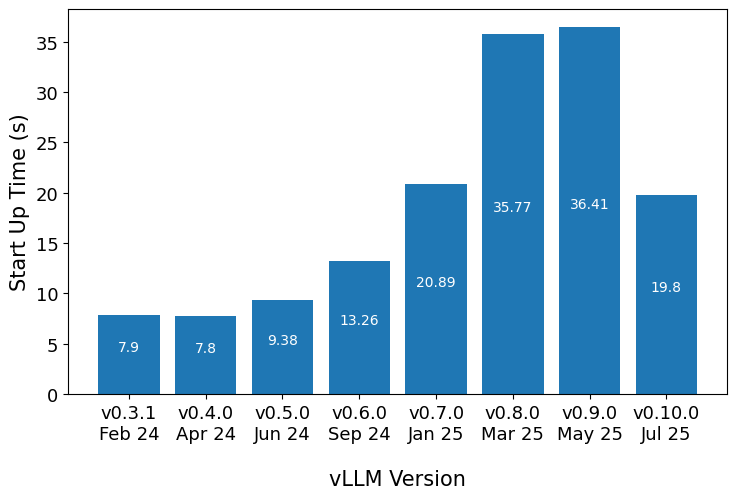

In [42]:
import matplotlib.pyplot as plt
import json

with open("examples/versions/avg_comparison_results.json", "r") as f:
    data = json.load(f)
    
labels = [label.split("_")[-1].split(".txt")[0] for label in data["labels"]]
values = [round(value, 2) for value in data["data"]["actual_total_time"]]
release_dates = ["Feb 24", "Apr 24", "Jun 24", "Sep 24", "Jan 25", "Mar 25", "May 25", "Jul 25"]

plt.figure(figsize=(8.5, 5))
bars = plt.bar([f"{l}\n{release_dates[i]}\n" for i,l in enumerate(labels)], values)
plt.ylabel("Start Up Time (s)", fontsize=15)
plt.xlabel("vLLM Version", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{value}', ha='center', va='bottom', fontsize=10, color="white")

plt.savefig(
    "figures/vllm-version-startuptime.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Figure 2: LLM requests are bursty

trace_kalos.csv: CV=0.987, Peak/Average=20.31


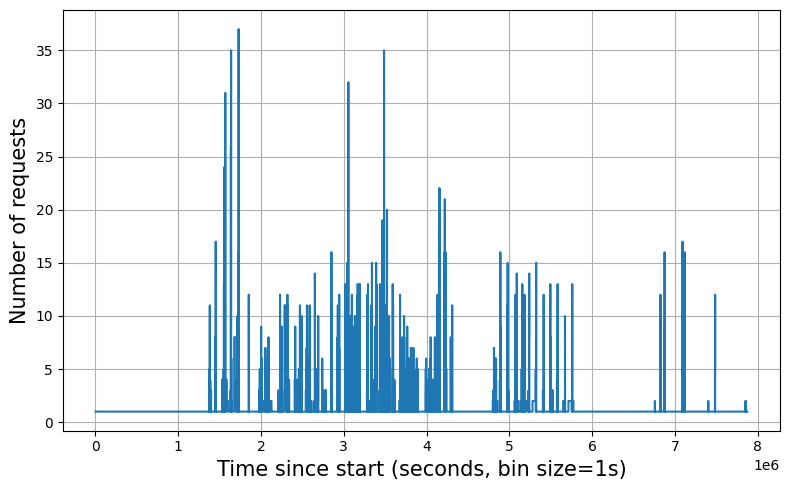

qwen_traceA_blksz_16.jsonl: CV=0.453, Peak/Average=2.99


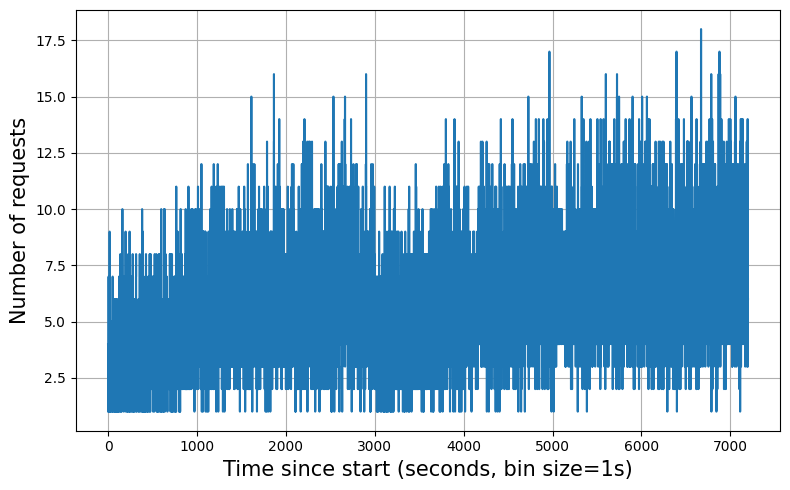

qwen_traceB_blksz_16.jsonl: CV=0.275, Peak/Average=2.17


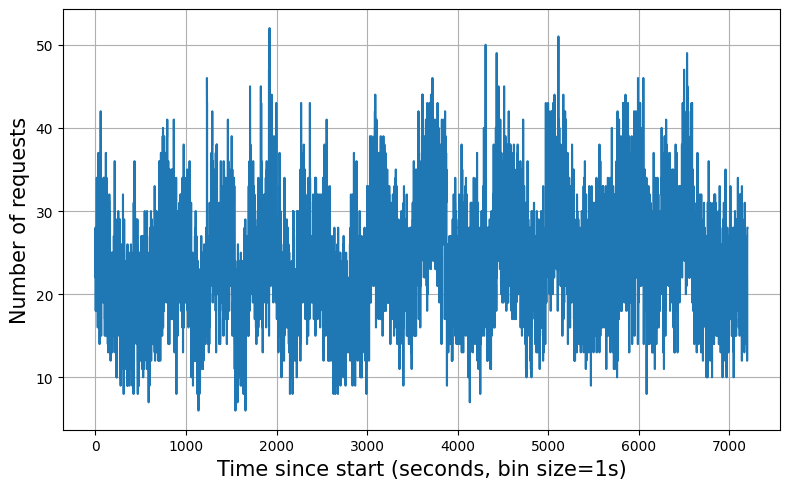

In [29]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def draw_traces(trace_files, filename, is_ms=True):
    bin_size = 1  # seconds per bin (adjust as needed)

    plt.figure(figsize=(8, 5))

    for file in trace_files:
        if file.endswith(".jsonl"):
            timestamps = []
            with open(file, "r") as f:
                for line in f:
                    data = json.loads(line)
                    timestamps.append(data["timestamp"])

            # Skip empty files
            if not timestamps:
                continue

            # Sort timestamps and normalize (convert to seconds & start from 0)
            timestamps.sort()
            timestamps = [t / 1000.0 if is_ms else t for t in timestamps]  # ms → sec
            start_time = timestamps[0]
            timestamps = [t - start_time for t in timestamps]  # relative time
            
            # Bin timestamps into fixed intervals
            binned = [int(t // bin_size) for t in timestamps]
            counts = Counter(binned)

            # Prepare data for plotting
            x = sorted(counts.keys())
            y = [counts[i] for i in x]

            # Calculate metrics
            y_arr = np.array(y)
            mean_y = np.mean(y_arr)
            std_y = np.std(y_arr)
            cv = std_y / mean_y if mean_y != 0 else float('nan')
            peak_to_avg = np.max(y_arr) / mean_y if mean_y != 0 else float('nan')
            print(f"{os.path.basename(file)}: CV={cv:.3f}, Peak/Average={peak_to_avg:.2f}")

            label = os.path.basename(file).replace(".jsonl", "")
            plt.plot(x, y, drawstyle="steps-mid", label=f"{label} (CV={cv:.2f}, P/A={peak_to_avg:.1f})")
        elif file.endswith(".csv"):
            time_column = "submit_time" # or "start_time"
            df = pd.read_csv(file, parse_dates=[time_column])
        
            # Convert to timestamps in seconds since start
            timestamps = (df[time_column] - df[time_column].min()).dt.total_seconds()
            timestamps = timestamps.dropna().sort_values()

            # Bin into intervals
            binned = (timestamps // bin_size).astype(int)
            counts = Counter(binned)

            x = sorted(counts.keys())
            y = [counts[i] for i in x]

            # Calculate metrics
            y_arr = np.array(y)
            mean_y = np.mean(y_arr)
            std_y = np.std(y_arr)
            cv = std_y / mean_y if mean_y != 0 else float('nan')
            peak_to_avg = np.max(y_arr) / mean_y if mean_y != 0 else float('nan')
            print(f"{os.path.basename(file)}: CV={cv:.3f}, Peak/Average={peak_to_avg:.2f}")

            label = file.split("/")[-1].replace(".csv", "")
            plt.plot(x, y, drawstyle="steps-mid", label=f"{label} (CV={cv:.2f}, P/A={peak_to_avg:.1f})")

    # === Styling ===
    plt.xlabel(f"Time since start (seconds, bin size={bin_size}s)", fontsize=15)
    plt.ylabel("Number of requests", fontsize=15)
    # plt.title("LLM Inference Request Burstiness Over Time")
    plt.grid(True)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(
        f"figures/{filename}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()
    
# draw_traces(["./traces/conversation_trace.jsonl"], "mooncake-trace")
# draw_traces(["./traces/toolagent_trace.jsonl"], "mooncake-trace")
draw_traces(["./traces/trace_kalos.csv"], "shangahi-trace")
# draw_traces(["./traces/trace_seren.csv"], "shangahi-trace")
draw_traces(["./traces/qwen_traceA_blksz_16.jsonl"], "alibaba-trace", False)
draw_traces(["./traces/qwen_traceB_blksz_16.jsonl"], "alibaba-trace", False)

### Util

In [108]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from utils import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from collections import defaultdict
import numpy as np
import matplotlib.cm as cm

def draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename, func=None):
    all_values = []
    labels = []
    matric2_values = []

    for i, iter_dir in enumerate(os.listdir(iterations_path)):
        json_filepath = os.path.join(iterations_path, iter_dir, "comparison_results.json")

        metrics, sorted_labels, sort_indices = get_labels_matrics(json_filepath, sort_by)
        metric_values = [metrics[metric1][sort_indices[i]] for i in range(len(sorted_labels))]
        model_names = [extract_model_name(label) for label in sorted_labels]
        if func:
            model_metric_nb = [func(label) for label in sorted_labels]
        else:
            model_metric_nb = [get_model_info(label, metric2) for label in sorted_labels]

        # Now sort the values and model names based on the number of metric
        sorted_indices = sorted(range(len(model_metric_nb)), key=lambda i: model_metric_nb[i])
        metric_values_sorted = [metric_values[i] for i in sorted_indices]
        model_names_sorted = [model_names[i] for i in sorted_indices]
        model_metric_nb_sorted = [model_metric_nb[i] for i in sorted_indices]

        
        values = []
        for j, model_name in enumerate(model_names_sorted):
            if model_name in model_names_map:
                values.append(metric_values_sorted[j])
                if i == 0:
                    matric2_values.append(model_metric_nb_sorted[j])
                    labels.append(model_names_map[model_name])
                
        all_values.append(values)

    import scipy.stats as stats

    # Compute mean and standard error for each bar
    all_values_np = np.array(all_values)  # shape: (num_runs, num_models)
    means = np.mean(all_values_np, axis=0)
    stderrs = stats.sem(all_values_np, axis=0)

    cmap = cm.get_cmap("tab10", len(labels))
    colors = [cmap(i) for i in range(len(labels))]

    # Main bar chart with error bars
    fig, ax = plt.subplots(figsize=(8, 5.5))
    bars = ax.bar(
        [f"{label} ({matric2_values[i]})" for i, label in enumerate(labels)],
        means,
        yerr=stderrs,
        capsize=10,
        color=colors,
        ecolor='black'
    )
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_xticks(range(len(labels)))
    
    xtick_labels = []
    rotation = 30
    if metric2 != "size":
        xtick_labels = [f"{label} ({matric2_values[i]})" for i, label in enumerate(labels)]
    else:
        xtick_labels = labels
    
    if func:
        xtick_labels = matric2_values
        rotation = 0
    
    ax.set_xticklabels(xtick_labels, rotation=rotation, ha='right', fontsize=13)
    ax.set_ylim(0, max(means + stderrs) * ylim_multiplier)

    # Add value of each bar on top
    for bar, value in zip(bars, means):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{value:.2f}",
            ha='center',
            va='bottom',
            fontsize=10,
            color='white',
        )
        
    # --- Create inset axes for the linear relationship ---
    # width and height are relative to the main axes (0 to 1)
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.1, -0.04, 1, 1), bbox_transform=ax.transAxes)  

    # Linear regression
    X = np.array(matric2_values).reshape(-1, 1)
    y = means
    reg = LinearRegression()
    reg.fit(X, y)
    y_pred = reg.predict(X)

    # Scatter + linear fit in inset
    # Scatter with matching colors
    for i in range(len(matric2_values)):
        ax_inset.scatter(matric2_values[i], means[i], color=colors[i], s=15)
    ax_inset.plot(matric2_values, y_pred, color='black', linestyle='--', linewidth=1)

    # Optional: annotate points in inset
    # point_counts = defaultdict(int)
    # def find_close_key(x, y, keys, tol_x=0.05, tol_y=0.01):
    #     for kx, ky in keys:
    #         if abs(kx - x) <= tol_x and abs(ky - y) <= tol_y:
    #             return (kx, ky)
    #     return (x, y)

    # for i, txt in enumerate(labels):
    #     x, y_val = matric2_values[i], means[i]
    #     close_key = find_close_key(x, y_val, point_counts.keys())
    #     count = point_counts[close_key]
    #     offset_y = 10 + count * 12
    #     ax_inset.annotate(
    #         txt,
    #         (x, y_val),
    #         textcoords="offset points",
    #         xytext=(0, offset_y),
    #         ha='center',
    #         fontsize=6,
    #         arrowprops=dict(arrowstyle='-', lw=0.5, color='gray')
    #     )
    #     point_counts[close_key] += 1

    ax_inset.set_xlabel(x2label, fontsize=9.5)
    ax_inset.set_ylabel(y2label, fontsize=9.5)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()
    plt.savefig(
        f"figures/{filename}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()

### Figure 3: Showing the relationship between tokenizer initialization and size

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


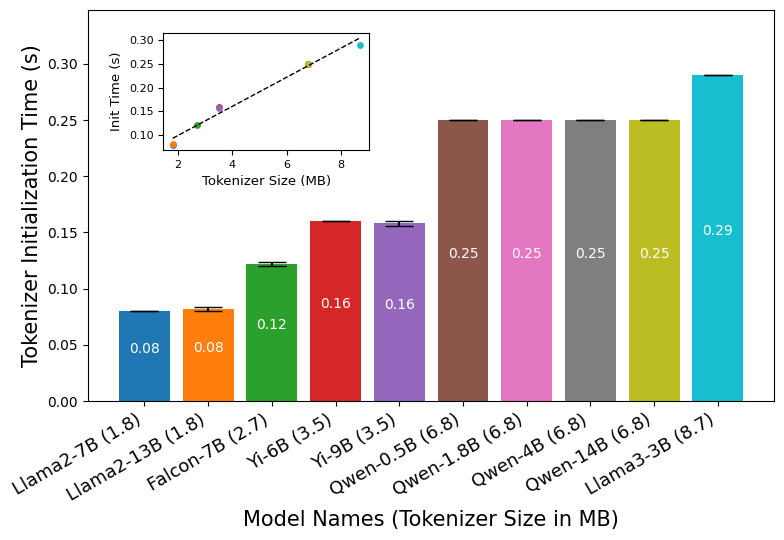

In [45]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "falcon-7b": "Falcon-7B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "llama3-3b": "Llama3-3B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "tokenizer_init"
metric2 = "tokenizer_size"
xlabel = "Model Names (Tokenizer Size in MB)"
ylabel = "Tokenizer Initialization Time (s)"
x2label = "Tokenizer Size (MB)"
y2label = "Init Time (s)"
ylim_multiplier = 1.2
filename = "init-tokenizer-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 4: Showing the relationship between loading weights and model size

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


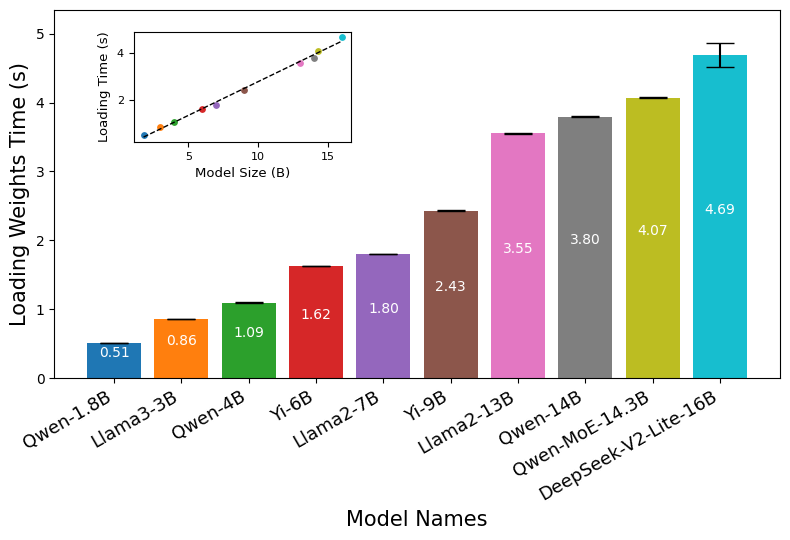

In [46]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "load_weights"
metric2 = "size"
xlabel = "Model Names"
ylabel = "Loading Weights Time (s)"
x2label = "Model Size (B)"
y2label = "Loading Time (s)"
ylim_multiplier = 1.1
filename = "load-weights-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 5: Showing the relationship between dynamo bytcode transform and number of layers

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


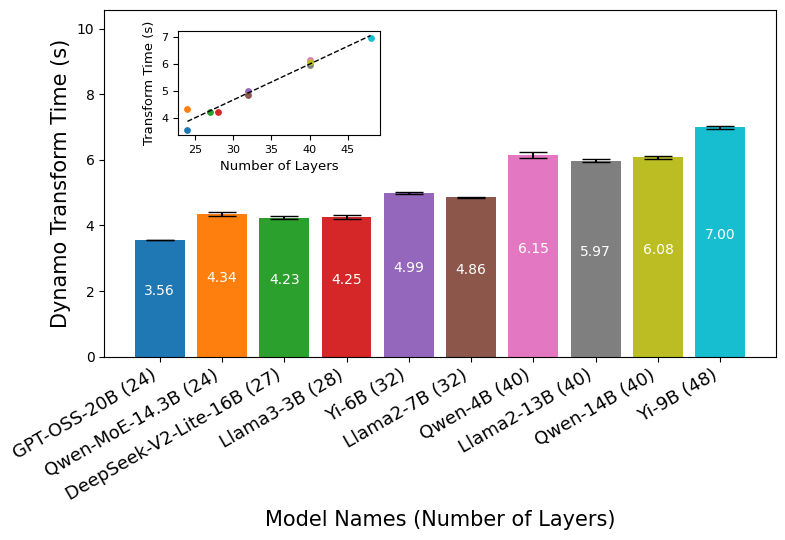

In [47]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    "gpt-oss-20b": "GPT-OSS-20B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "dynamo_transform_time"
metric2 = "layers"
xlabel = "Model Names (Number of Layers)"
ylabel = "Dynamo Transform Time (s)"
x2label = "Number of Layers"
y2label = "Transform Time (s)"
ylim_multiplier = 1.5
filename = "dynamo-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 6: Showing the relationship between loading compile graph and number of layers

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


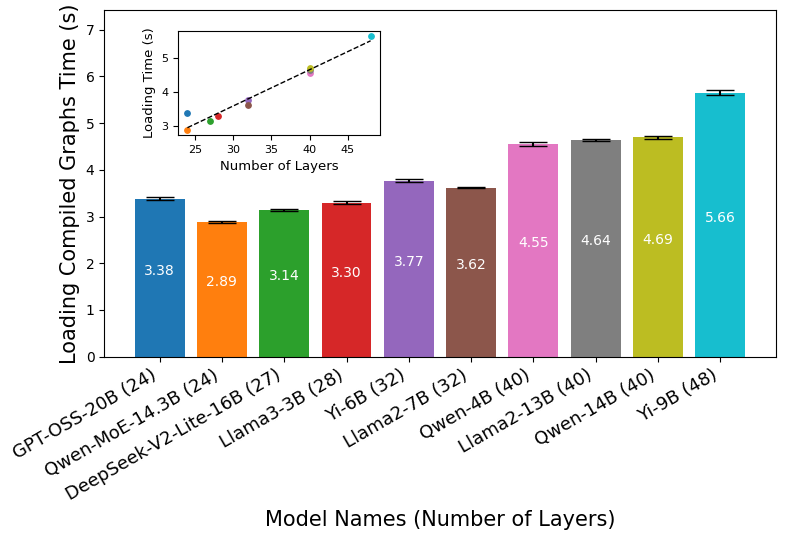

In [48]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    "gpt-oss-20b": "GPT-OSS-20B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "graph_compile_cached"
metric2 = "layers"
xlabel = "Model Names (Number of Layers)"
ylabel = "Loading Compiled Graphs Time (s)"
x2label = "Number of Layers"
y2label = "Loading Time (s)"
ylim_multiplier = 1.3
filename = "load-graphs-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 7: Showing the relationship between KV cache profiling and model size

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


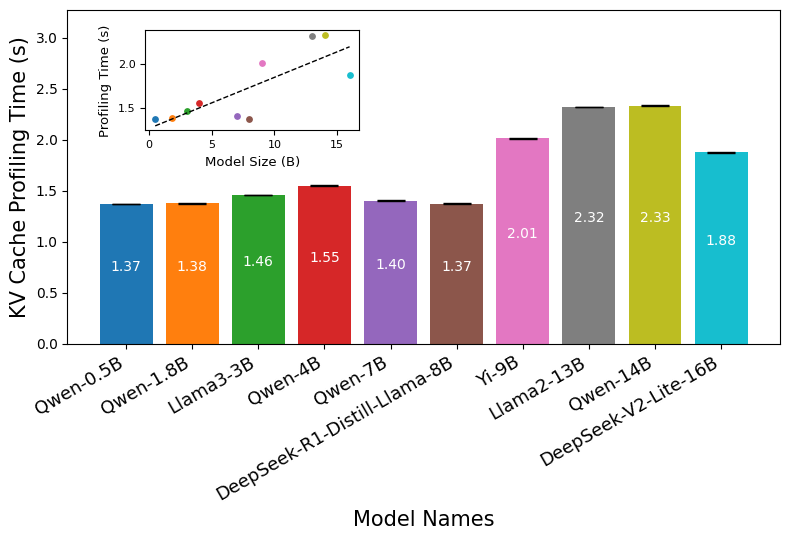

In [49]:
model_names_map = {
    "llama2-13b-hf": "Llama2-13B",
    "yi-9b": "Yi-9B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-7b": "Qwen-7B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "llama3-3b": "Llama3-3B",
    "deepseek-r1-distill-llama-8b": "DeepSeek-R1-Distill-Llama-8B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "kv_cache_profiling"
metric2 = "size"
xlabel = "Model Names"
ylabel = "KV Cache Profiling Time (s)"
x2label = "Model Size (B)"
y2label = "Profiling Time (s)"
ylim_multiplier = 1.4
filename = "kv-cache-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 8: Showing the relationship between graph capturing and model size

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


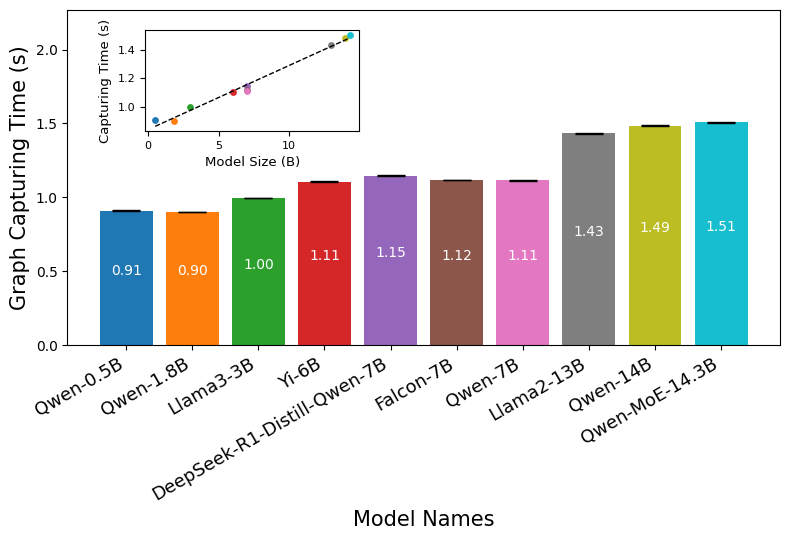

In [50]:
model_names_map = {
    "llama2-13b-hf": "Llama2-13B",
    "falcon-7b": "Falcon-7B",
    "yi-6b": "Yi-6B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-7b": "Qwen-7B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-r1-distill-qwen-7b": "DeepSeek-R1-Distill-Qwen-7B",
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "graph_capturing"
metric2 = "size"
xlabel = "Model Names"
ylabel = "Graph Capturing Time (s)"
x2label = "Model Size (B)"
y2label = "Capturing Time (s)"
ylim_multiplier = 1.5
filename = "cuda-graph-model-size"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 9: Showing the relationship between graph capturing and number of batch sizes

/tmp/ipykernel_286573/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_286573/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


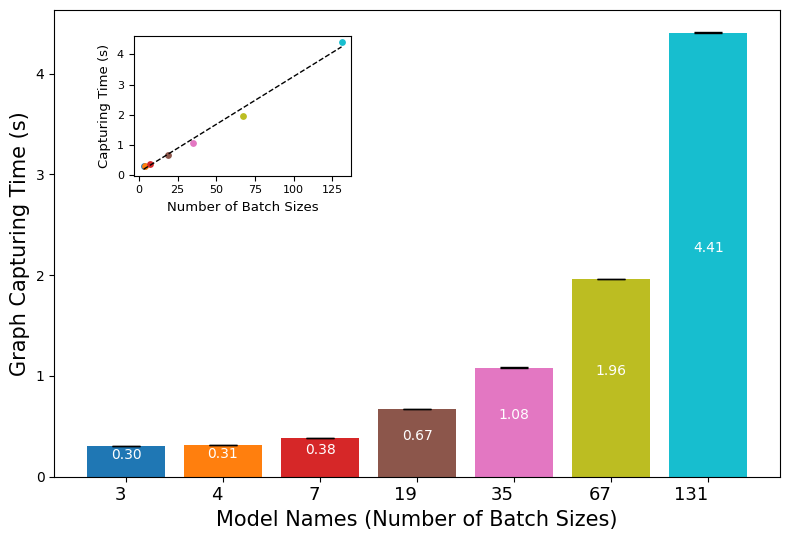

In [51]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
}
iterations_path = "examples/batch_size/iterations"
sort_by = "model_size"
metric1 = "graph_capturing"
metric2 = "size"
xlabel = "Model Names (Number of Batch Sizes)"
ylabel = "Graph Capturing Time (s)"
x2label = "Number of Batch Sizes"
y2label = "Capturing Time (s)"
ylim_multiplier = 1.05
filename = "cuda-graph-batch-size"
func = extract_batch_size
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename, func)

### Figure 11: Validation of the predictor 



train
falcon-7b | Predicted: 13.581s | Truth: 12.926 | Diff: 0.66
llama2-13b-hf | Predicted: 17.012s | Truth: 18.13 | Diff: 1.12
llama2-7b-hf | Predicted: 13.561s | Truth: 12.944 | Diff: 0.62
llama3-3b | Predicted: 11.750s | Truth: 11.28 | Diff: 0.47
qwen-0.5b | Predicted: 10.103s | Truth: 9.102 | Diff: 1.00
qwen-1.8b | Predicted: 10.420s | Truth: 9.574 | Diff: 0.85
qwen-14b | Predicted: 17.372s | Truth: 18.764 | Diff: 1.39
qwen-4b | Predicted: 14.930s | Truth: 14.994 | Diff: 0.06
qwen-7b | Predicted: 13.674s | Truth: 13.614 | Diff: 0.06
yi-6b | Predicted: 13.356s | Truth: 13.14 | Diff: 0.22
yi-9b | Predicted: 18.061s | Truth: 18.842 | Diff: 0.78
Diff: 7.22 | Avg: 0.66


validation
falcon-11b | Predicted: 21.511s | Truth: 22.644 | Diff: 1.13
mistral-7b | Predicted: 13.561s | Truth: 14.29 | Diff: 0.73
mpt-7b | Predicted: 13.568s | Truth: 9.754 | Diff: 3.81
olmoe-7b | Predicted: 9.595s | Truth: 10.434 | Diff: 0.84
gemma-7b | Predicted: 12.931s | Truth: 15.076 | Diff: 2.15
Diff: 8.66 | 

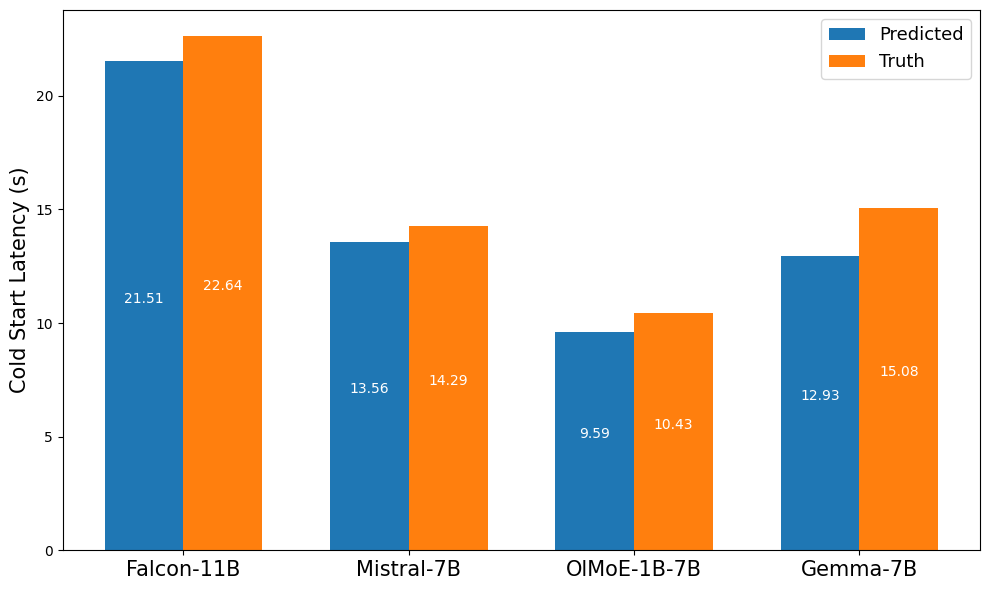

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from predictor.run_predictor import predict

model_names_map = {
    "falcon-11b": "Falcon-11B",
    "mistral-7b": "Mistral-7B",
    "olmoe-7b": "OlMoE-1B-7B",
    "gemma-7b": "Gemma-7B"
}

results = predict("predictor_info/models", "predictor_info/test_data.json")["validation"]

print(results)
# Data
models = []
predicted = []
truth = []
diff = []
for x in results:
    label = x["label"]
    if label in model_names_map:
        models.append(model_names_map[label])
        predicted.append(x["predicted"])
        truth.append(x["truth"])
        diff.append(x["diff"])
    
x = np.arange(len(models))
width = 0.35  # bar width

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars: Predicted vs Truth
bars1 = ax1.bar(x - width/2, predicted, width, label="Predicted")
bars2 = ax1.bar(x + width/2, truth, width, label="Truth")

for bar in bars1 + bars2:
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=10, color='white')

ax1.set_ylabel("Cold Start Latency (s)", fontsize=15)
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=15)
ax1.legend(fontsize=13)

plt.tight_layout()
plt.savefig(
    "figures/predictor-validation.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()


### Figure 10: Impact of Different GPU (Node 5 vs Node 7)

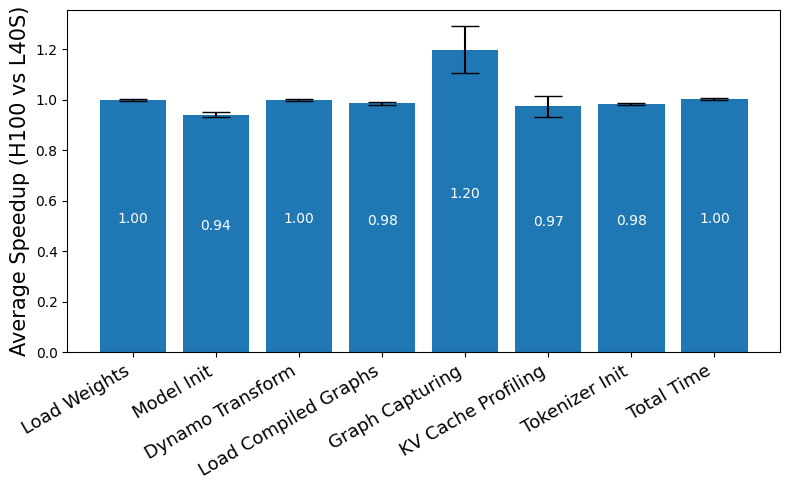

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from compare_2_avgs import compare_files

def compare_2_archs(filepath1, filepath2, verbosity, title, pdf_name):
    steps_map = {
        "load_weights": "Load Weights",
        "model_init": "Model Init",
        "dynamo_transform_time": "Dynamo Transform",
        "graph_compile_cached": "Load Compiled Graphs",
        "graph_capturing": "Graph Capturing",
        "kv_cache_profiling": "KV Cache Profiling",
        "tokenizer_init": "Tokenizer Init",
        # "total_time": "Total Time",
        "actual_total_time": "Total Time",
    }

    output_results = compare_files(filepath1, filepath2, verbosity)


    steps = list(output_results.keys())
    avg_speedups = []
    stderr_speedups = []
    xticklabels = []
    for step in steps:
        if step in steps_map:
            speedups = [entry["speedup"] for entry in output_results[step]]
            avg_speedups.append(np.mean(speedups))
            stderr_speedups.append(stats.sem(speedups))
            xticklabels.append(steps_map[step])

    x = np.arange(len(xticklabels))
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(x, avg_speedups, yerr=stderr_speedups, capsize=10, ecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, rotation=30, ha='right', fontsize=13)
    ax.set_ylabel(title, fontsize=15)

    # Annotate each bar with its value
    for bar, value in zip(bars, avg_speedups):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{value:.2f}", ha='center', va='bottom', fontsize=10, color='white')

    plt.tight_layout()
    plt.savefig(
        f"figures/{pdf_name}",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()
    
    
h100_filepath = "examples/model_size/avg_comparison_results.json"
l40s_filepath = "../node5/examples/model_size/avg_comparison_results.json"
verbosity = None
title = "Average Speedup (H100 vs L40S)"
pdf_name = "h100-vs-l40s.pdf"
compare_2_archs(h100_filepath, l40s_filepath, verbosity, title, pdf_name)

### Figure 11: Impact of Different CPU (Node 7 vs t1 vs t2)

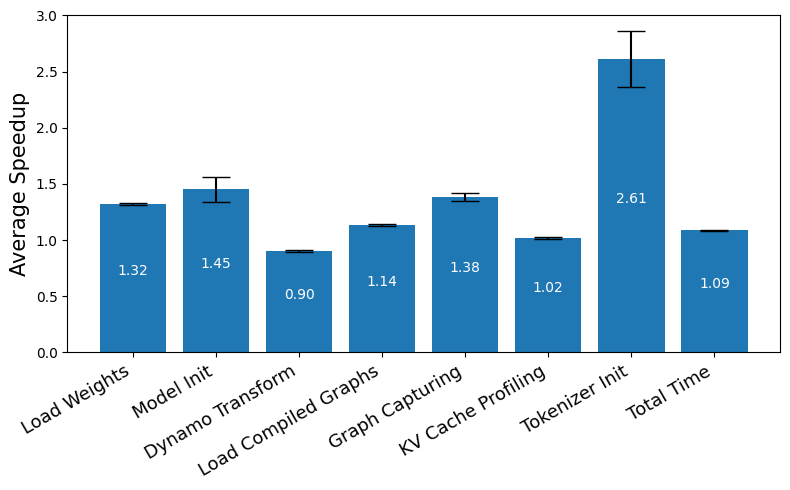

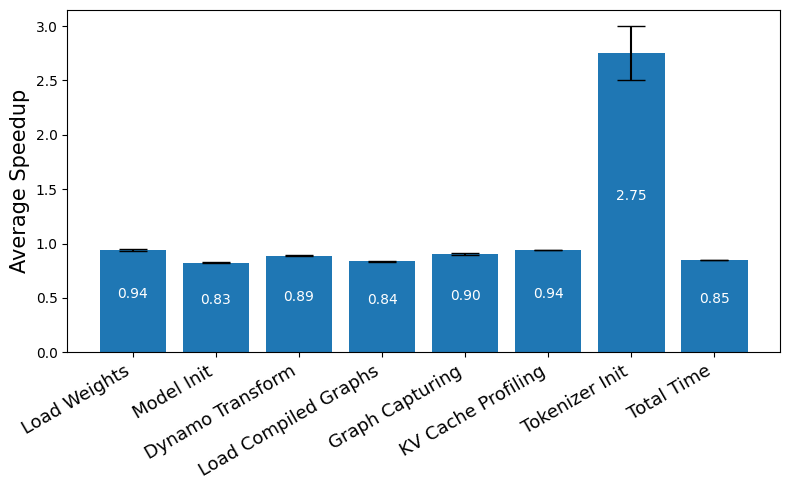

In [5]:
node7_filepath = "examples/model_size/avg_comparison_results.json"
t1_filepath = "../t1/examples/model_size/avg_comparison_results.json"
verbosity = None
title = "Average Speedup"
pdf_name = "node7-vs-t1.pdf"
compare_2_archs(node7_filepath, t1_filepath, verbosity, title, pdf_name)

node5_filepath = "../node5/examples/model_size/avg_comparison_results.json"
t2_filepath = "../t2/examples/model_size/avg_comparison_results.json"
verbosity = None
title = "Average Speedup"
pdf_name = "node5-vs-t2.pdf"
compare_2_archs(node5_filepath, t2_filepath, verbosity, title, pdf_name)

### Figure 12: Impact of SSD

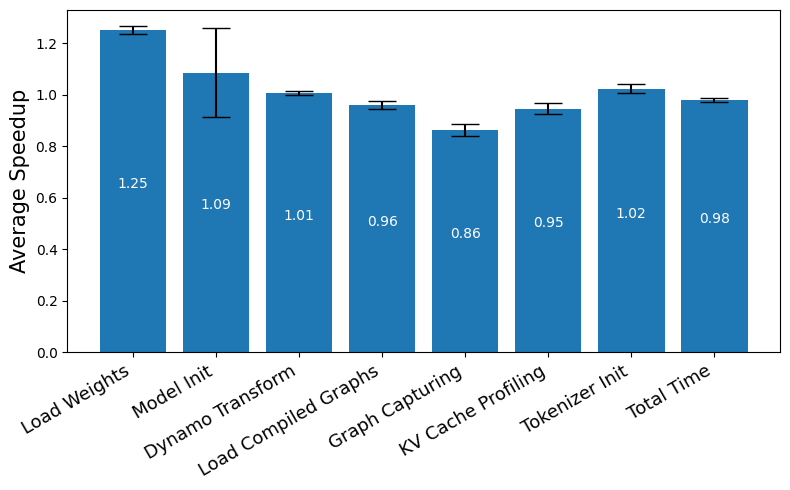

In [30]:
t1_filepath = "../t1/examples/model_size/avg_comparison_results.json"
t1_ssd_filepath = "../t1/examples/ssd/avg_comparison_results.json"
verbosity = None
title = "Average Speedup"
pdf_name = "impact-of-ssd.pdf"
compare_2_archs(t1_filepath, t1_ssd_filepath, verbosity, title, pdf_name)

### Figure 13: Impact of Loading Methods

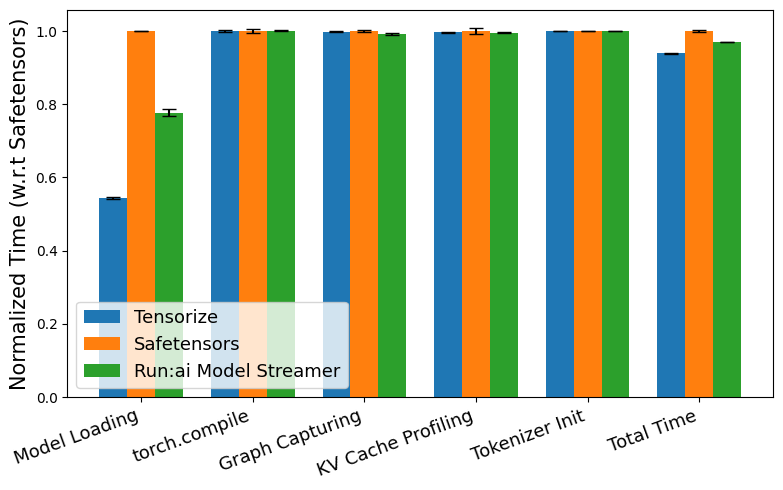

In [63]:
import json
import matplotlib.pyplot as plt
import numpy as np

all_files_contents = []
for i in range (1, 6):
    iterations_path = f"./examples/loading_methods/iterations/{i}"
    json_filepath = os.path.join(iterations_path, "comparison_results.json")
    with open(json_filepath, "r") as f:
        file_content = json.load(f)
        all_files_contents.append(file_content)
        
labels = ["Tensorize", "Safetensors", "Run:ai Model Streamer"]
data = {label: {} for label in labels}

for file_content in all_files_contents:
    for step, values in file_content["data"].items():
        for i, label in enumerate(data.keys()):
            if step not in data[label]:
                data[label][step] = []
            data[label][step].append(values[i])


steps_map = {
    "model_loading": "Model Loading",
    "torch.compile": "torch.compile",
    "graph_capturing": "Graph Capturing",
    "kv_cache_profiling": "KV Cache Profiling",
    "tokenizer_init": "Tokenizer Init",
    "actual_total_time": "Total Time",
} 

# Normalize values relative to "Safetensors"
ref_method = "Safetensors"

steps = steps_map.keys()
methods = list(data.keys())
x = np.arange(len(steps))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))

# Compute normalized values
for i, method in enumerate(methods):
    means = []
    stderrs = []
    for s in steps:
        ref_mean = np.mean(data[ref_method][s])
        method_mean = np.mean(data[method][s])
        method_std = np.std(data[method][s], ddof=1) / np.sqrt(len(data[method][s]))
        if ref_mean != 0:
            means.append(method_mean / ref_mean)
            stderrs.append(method_std / ref_mean)
        else:
            means.append(0)
            stderrs.append(0)
    ax.bar(x + i*width, means, width, yerr=stderrs, capsize=5, label=method)

ax.set_xticks(x + width)
ax.set_xticklabels([steps_map[s] for s in steps], rotation=20, ha='right', fontsize=13)
ax.set_ylabel('Normalized Time (w.r.t Safetensors)', fontsize=15)
ax.legend(fontsize=13)

plt.tight_layout()
plt.savefig(
    f"figures/diff-loading-methods.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Impact of uncached graphs

/tmp/ipykernel_560857/1128128115.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(labels))
/tmp/ipykernel_560857/1128128115.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


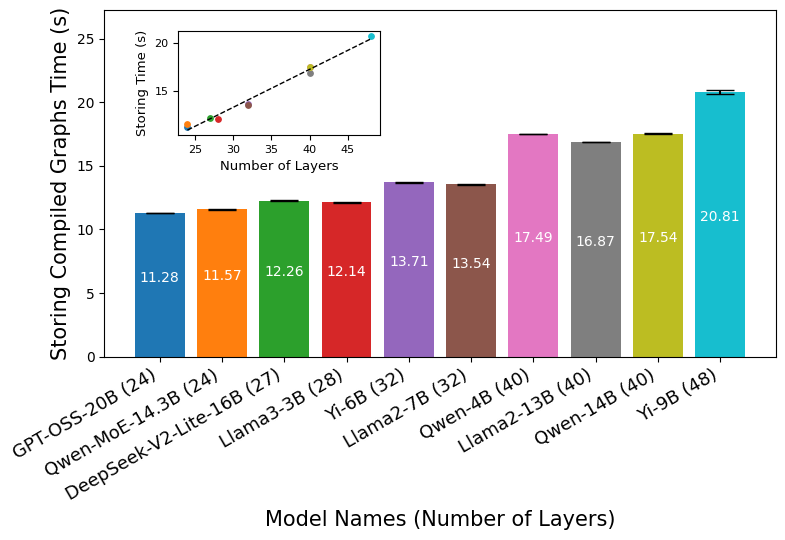

In [109]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    "gpt-oss-20b": "GPT-OSS-20B"
}
iterations_path = "examples/uncached_graphs/iterations"
sort_by = "model_size"
metric1 = "graph_compile_general_shape"
metric2 = "layers"
xlabel = "Model Names (Number of Layers)"
ylabel = "Storing Compiled Graphs Time (s)"
x2label = "Number of Layers"
y2label = "Storing Time (s)"
ylim_multiplier = 1.3
filename = "store-graphs-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

In [111]:
import numpy as np

x1 = [11.28, 11.57, 12.26, 12.14, 13.71, 13.54, 17.49, 16.87, 17.54, 20.81]
x2 = [3.38, 2.89, 3.14, 3.30, 3.77, 3.62, 4.55, 4.64, 4.69, 5.66]

x1 = np.array(x1)
x2 = np.array(x2)

speedups = x1 / x2
avg_speedup = np.mean(speedups)
print(speedups)
print("Average speedup:", avg_speedup)

[3.33727811 4.00346021 3.9044586  3.67878788 3.63660477 3.74033149
 3.84395604 3.63577586 3.73987207 3.67667845]
Average speedup: 3.7197203477368808


### Impact of tmpfs

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os


def read_iterations(dir_name):
    files_contents = []
    for i in range (1, 6):
        iterations_path = os.path.join(dir_name, str(i))
        json_filepath = os.path.join(iterations_path, "comparison_results.json")
        with open(json_filepath, "r") as f:
            file_content = json.load(f)
            files_contents.append(file_content)
            
    return files_contents

def parse_data(path, labels, suffix):

    files_contents = []
    files_contents = read_iterations(path)
    data = {label: {} for label in labels}
    labels_indices = {label: 0 for label in labels}
    for i,label in enumerate(files_contents[0]["labels"]):
        for key in labels_indices.keys():
            if key.lower() in label and suffix in label:
                labels_indices[key] = i

    for i,file_content in enumerate(files_contents):
        for step, values in file_content["data"].items():
            for label,index in labels_indices.items():
                if step not in data[label]:
                    data[label][step] = []
                data[label][step].append(values[index])
              
    return data

def compare_versions(path, old_suffix, new_suffix, labels, filename):
    
    data_new = parse_data(path, labels, old_suffix)
    data_default = parse_data(path, labels, new_suffix)
    
    steps_map = {
        "model_loading": "Model Loading",
        "torch.compile": "torch.compile",
        "graph_capturing": "Graph Capturing",
        "kv_cache_profiling": "KV Cache Profiling",
        "tokenizer_init": "Tokenizer Init",
        "actual_total_time": "Total Time",
    } 

    models = list(data_new.keys())
    steps = steps_map.keys()

    ratios = {model: [] for model in models}
    errors = {model: [] for model in models}

    for step in steps:
        for model in models:
            vals = np.array(data_new[model][step], dtype=float)
            ref_vals = np.array(data_default[model][step], dtype=float)

            # Compute mean ratio and stderr
            ratio = vals.mean() / ref_vals.mean()
            stderr = ratio * np.sqrt((vals.std()/vals.mean())**2/len(vals) +
                                    (ref_vals.std()/ref_vals.mean())**2/len(ref_vals))
            ratios[model].append(ratio)
            errors[model].append(stderr)

    # --- Plot ---
    x = np.arange(len(steps))
    width = 0.3

    fig, ax = plt.subplots(figsize=(8, 5))

    for i, model in enumerate(models):
        bars = ax.bar(x + i*width, ratios[model], width, yerr=errors[model],
                    label=model, capsize=4)
        # Annotate each bar with its value
        for bar, val in zip(bars, ratios[model]):
            ax.annotate(f"{val:.2f}", 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color="white")

    ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylabel("Normalized time", fontsize=15)
    ax.set_xticks(x + width)
    ax.set_xticklabels([steps_map[s] for s in steps], rotation=20, ha='right', fontsize=13)
    ax.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig(
        f"figures/{filename}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()

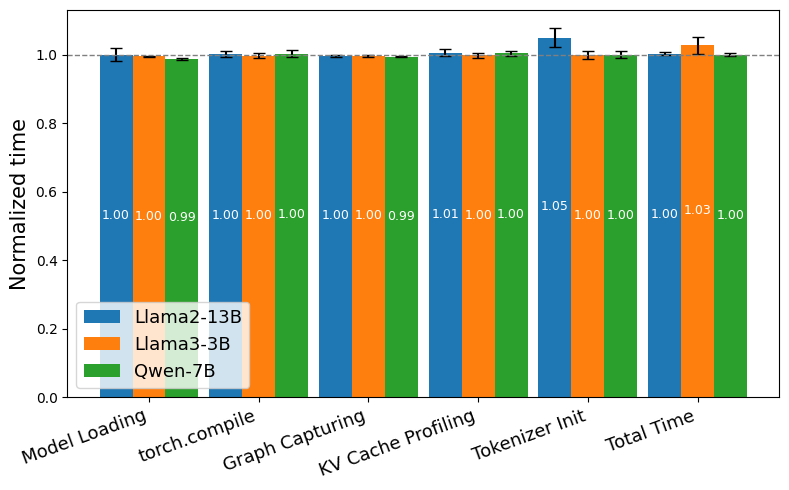

In [65]:
path = "./examples/tmpfs/iterations/"
labels = ["Llama2-13B", "Llama3-3B", "Qwen-7B"]
filename = "tmpfs"

compare_versions(path, "default", "tmpfs", labels, filename)

### Impact of PyTorch Versions

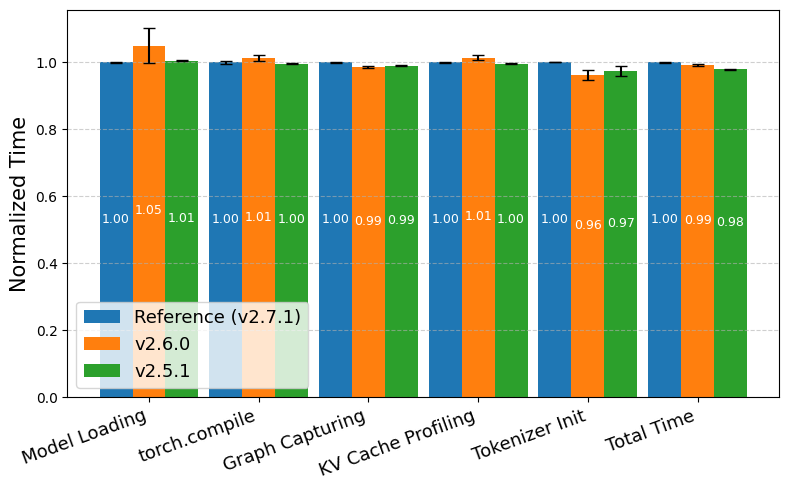

In [68]:
import numpy as np
import matplotlib.pyplot as plt

path = "./examples/pytorch_versions/iterations/"
model_labels = ["Yi-9B"]
filename = "pytorch"

default_data = parse_data(path, model_labels, "default")
torch2_6_0_data = parse_data(path, model_labels, "torch2.6.0")
torch2_5_1_data = parse_data(path, model_labels, "torch2.5.1")

dicts = [default_data, torch2_6_0_data, torch2_5_1_data]
labels = ['Reference (v2.7.1)', 'v2.6.0', 'v2.5.1']

steps_map = {
    "model_loading": "Model Loading",
    "torch.compile": "torch.compile",
    "graph_capturing": "Graph Capturing",
    "kv_cache_profiling": "KV Cache Profiling",
    "tokenizer_init": "Tokenizer Init",
    "actual_total_time": "Total Time",
} 

# --- Compute mean and stderr ---
steps = steps_map.keys()
means = []
stderrs = []

for d in dicts:
    d_means = []
    d_stds = []
    for step in steps:
        values = [x for x in d[model_labels[0]][step] if x is not None]
        mean = np.mean(values)
        stderr = np.std(values, ddof=1) / np.sqrt(len(values))
        d_means.append(mean)
        d_stds.append(stderr)
    means.append(d_means)
    stderrs.append(d_stds)

# --- Normalize by reference means ---
ref_means = np.array(means[0])
norm_means = [np.array(m) / ref_means for m in means]
norm_stderrs = [np.array(s) / ref_means for s in stderrs]

# --- Plot ---
x = np.arange(len(steps))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
for i in range(len(dicts)):
    bars = ax.bar(x + i * width, norm_means[i], width, yerr=norm_stderrs[i], label=labels[i], capsize=4)
    for bar, val in zip(bars, norm_means[i]):
            ax.annotate(f"{val:.2f}", 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color="white")

ax.set_xticks(x + width)
ax.set_xticklabels([steps_map[s] for s in steps], rotation=20, ha='right', fontsize=13)
ax.set_ylabel('Normalized Time', fontsize=15)
ax.legend(fontsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(
    f"figures/pytorch-versions.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Different vLLM Params

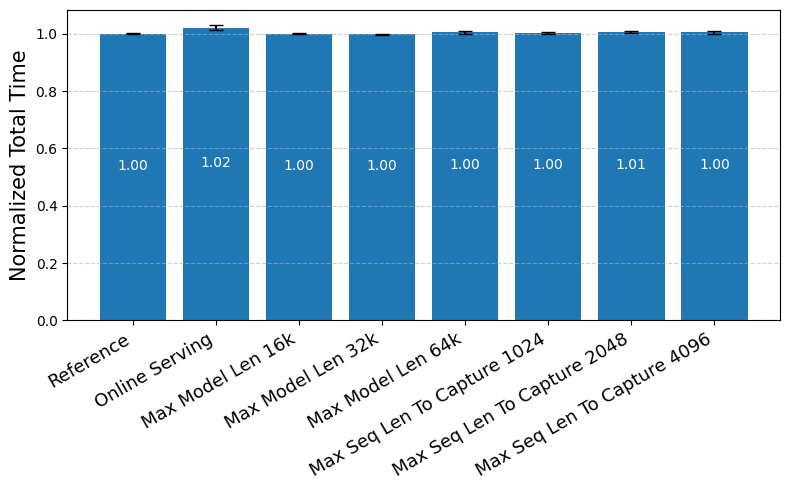

In [69]:
import numpy as np
import matplotlib.pyplot as plt

path = "./examples/vllm_params/iterations/"
model_labels = ["LLama3-3B"]
filename = "vllm-params"

offline_data = parse_data(path, model_labels, "offline-serving")
online_data = parse_data(path, model_labels, "online-serving")
max_model_len_16k_data = parse_data(path, model_labels, "max-model-len_16k")
max_model_len_32k_data = parse_data(path, model_labels, "max-model-len_32k")
max_model_len_64k_data = parse_data(path, model_labels, "max-model-len_64k")
max_model_seq_len_1024_data = parse_data(path, model_labels, "max-seq-len-to-capture_1024")
max_model_seq_len_2048_data = parse_data(path, model_labels, "max-seq-len-to-capture_2048")
max_model_seq_len_4096_data = parse_data(path, model_labels, "max-seq-len-to-capture_4096")

dicts = [
    offline_data,
    online_data,
    max_model_len_16k_data,
    max_model_len_32k_data,
    max_model_len_64k_data,
    max_model_seq_len_1024_data,
    max_model_seq_len_2048_data,
    max_model_seq_len_4096_data
]

labels = [
    "Reference",
    "Online Serving",
    "Max Model Len 16k",
    "Max Model Len 32k",
    "Max Model Len 64k",
    "Max Seq Len To Capture 1024",
    "Max Seq Len To Capture 2048",
    "Max Seq Len To Capture 4096",
]

means, stderrs = [], []
for d in dicts:
    vals = d[model_labels[0]]['actual_total_time']
    mean = np.mean(vals)
    stderr = np.std(vals, ddof=1) / np.sqrt(len(vals))
    means.append(mean)
    stderrs.append(stderr)

# --- Normalize relative to the first dict (reference) ---
ref_mean = means[0]
norm_means = [m / ref_mean for m in means]
norm_stderrs = [s / ref_mean for s in stderrs]

# --- Plot ---
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x, norm_means, yerr=norm_stderrs, capsize=5)
for bar, val in zip(bars, norm_means):
    ax.annotate(f"{val:.2f}", 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color="white")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=13)
ax.set_ylabel("Normalized Total Time", fontsize=15)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(
    f"figures/vllm_params.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()


### Impact Of Containerization

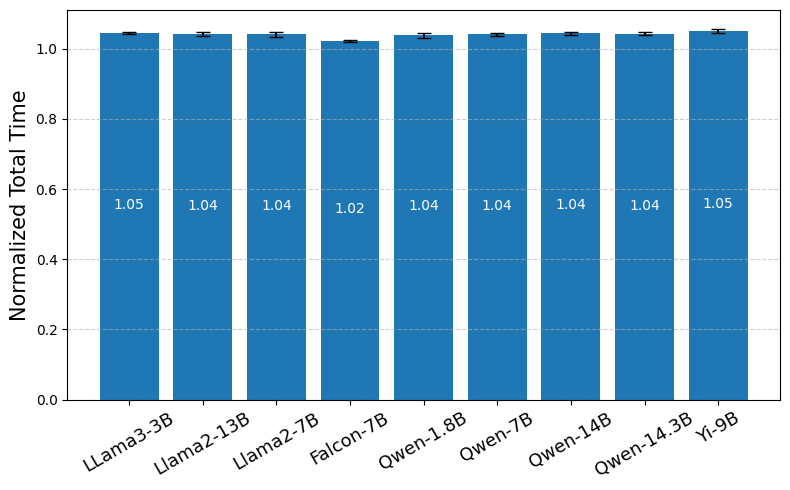

In [19]:
path = "./examples/docker_container/iterations/"
model_labels = ["LLama3-3B", "Llama2-13B", "Llama2-7B", "Falcon-7B", "Qwen-1.8B", "Qwen-7B", "Qwen-14B", "Qwen-14.3B", "Yi-9B"]

data_new = parse_data(path, model_labels, "container")
data_default = parse_data(path, model_labels, "default")

step = "actual_total_time"

models = list(data_new.keys())
ratios = []
stderr = []

for m in models:
    vals1 = np.array(data_new[m][step])
    vals2 = np.array(data_default[m][step])
    ratio = vals2 / vals1  # element-wise normalization
    ratios.append(np.mean(ratio))
    stderr.append(np.std(ratio, ddof=1) / np.sqrt(len(ratio)))  # standard error

# ---- Plot ----
plt.figure(figsize=(8, 5))
bars = plt.bar(models, ratios, yerr=stderr, capsize=5)
for bar, val in zip(bars, ratios):
    plt.annotate(f"{val:.2f}", 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color="white")

plt.ylabel('Normalized Total Time', fontsize=15)
plt.xticks(rotation=30, fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(
    f"figures/docker-container.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Tokenizer size vs vocab size

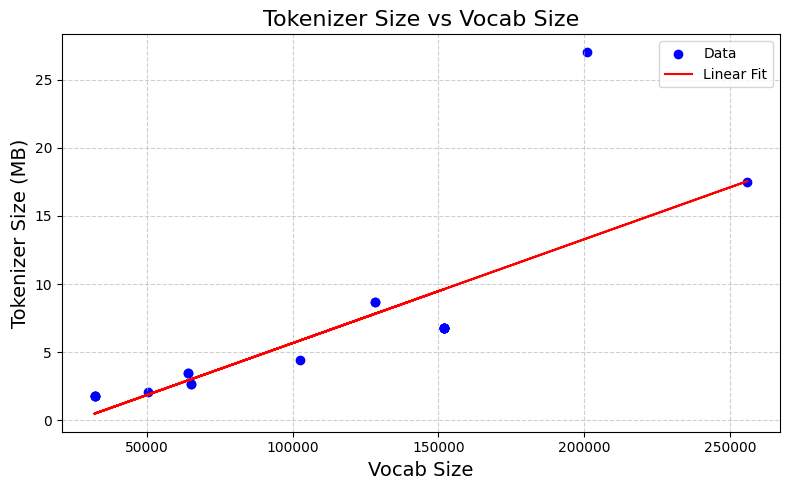

In [54]:
import json 
import matplotlib.pyplot as plt

model_configs = {}
with open("../../../vllm-profiling/models_config.json", "r") as f:
    model_configs = json.load(f)
    
tokenizer_sizes = [values["tokenizer_size"] for _,values in model_configs.items()]
vocab_sizes = [values["vocab_size"] for _,values in model_configs.items()]
model_names = [key for key, _ in model_configs.items()]

plt.figure(figsize=(8, 5))
plt.scatter(vocab_sizes, tokenizer_sizes, color='blue', label='Data')

# Fit linear regression
X = np.array(vocab_sizes).reshape(-1, 1)
y = np.array(tokenizer_sizes)
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

plt.plot(vocab_sizes, y_pred, color='red', label='Linear Fit')
plt.xlabel("Vocab Size", fontsize=14)
plt.ylabel("Tokenizer Size (MB)", fontsize=14)
plt.title("Tokenizer Size vs Vocab Size", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
# Annotate each point with its model name
# for i, name in enumerate(model_names):
#     plt.annotate(name, (vocab_sizes[i], tokenizer_sizes[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.tight_layout()
plt.show()